In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import glob
from lxml import etree

import time

In [2]:
gpus = tf.config.experimental.list_physical_devices( device_type = 'GPU' )
# 设置该程序可见的GPU：写到最前面！
tf.config.experimental.set_visible_devices( devices = gpus[0:4], device_type = 'GPU' )

### 1. 图像信息显示：仅是查看单张图阶段

TensorShape([400, 600, 3])

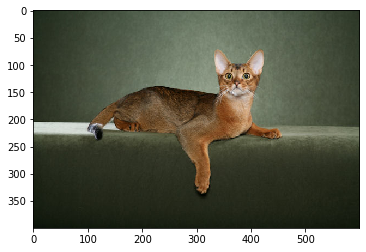

In [3]:
# 文件读取：
img = tf.io.read_file( '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_1.jpg' )
img = tf.image.decode_jpeg(img)
plt.imshow(img)
img.shape

In [4]:
# 头部控制点文件读取：
xml = open( '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_1.xml' ).read()
# 文本内容抓取：
select = etree.HTML(xml)
# 在size分支下，抓取width和height标签的数据：开头必须是//
width = int( select.xpath( '//size/width/text()' )[0] )      # 宽是x向
height = int( select.xpath( '//size/height/text()' )[0] )    # 高是y向
xmin = int( select.xpath( '//bndbox/xmin/text()' )[0] )
ymin = int( select.xpath( '//bndbox/ymin/text()' )[0] )
xmax = int( select.xpath( '//bndbox/xmax/text()' )[0] )
ymax = int( select.xpath( '//bndbox/ymax/text()' )[0] )

xmin, ymin, xmax, ymax, width, height

(333, 72, 425, 158, 600, 400)

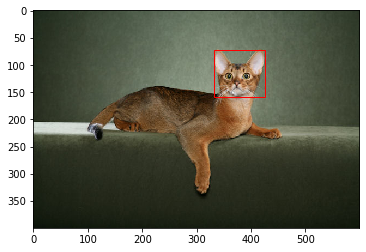

In [5]:
# 画图显示：
# 画矩形框的：(左下角坐标, x向宽度, y向高度, 框内是否填充, 框线是什么颜色)
from matplotlib.patches import Rectangle  
Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 

plt.imshow( img )
ax = plt.gci()  # gci = get current image：获得当前图像的句柄，即后面操作还在当前图上进行
ax.axes.add_patch( Rect )
plt.show()

### 2. 图像预处理：仅是查看单张图阶段

In [6]:
# 先标准化：
img = img / 255

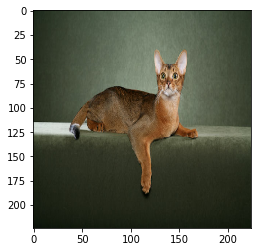

In [7]:
new_height = 224
new_width = 224  
# 等比例放缩放(224,224)：
img = tf.image.resize(img, [new_height,new_width])  # 先高度，再宽度
plt.imshow(img) 

In [8]:
# 4个头部控制点也按同比例放缩：
xmin = ( xmin / width ) * new_width
ymin = ( ymin / height ) * new_height
xmax = ( xmax / width ) * new_width
ymax = ( ymax / height ) * new_height

xmin, xmax, ymin, ymax

(124.32000000000001, 158.66666666666669, 40.32, 88.48)

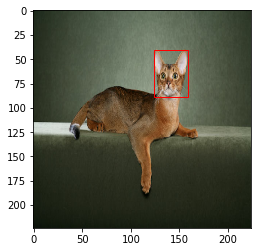

In [9]:
# 画图查看：
Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 
plt.imshow( img )
ax = plt.gci()
ax.axes.add_patch( Rect )
plt.show()

### 3. 获取所有文件的路径：**正式工作开始**！

In [10]:
# 获取所有图片文件地址：
all_image_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/*.jpg' )
len(all_image_path)

7390

In [11]:
# 获取所有位置文件地址：
all_xml_path = glob.glob( '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/*.xml' )
len(all_xml_path)

3686

In [12]:
# 获得所有位置文件的标签：中间过渡变量！
all_xml_name = [ x.split('/')[-1].split('.')[0] for x in all_xml_path ]
print( len(all_xml_name) )
all_xml_name[0:2]

3686


['Abyssinian_1', 'Abyssinian_10']

In [13]:
# 获取所有有效图像的地址：有配套的位置文件的那些图
useful_image_path = [ img for img in all_image_path if img.split('/')[-1].split('.')[0] in all_xml_name ]
print( len(useful_image_path) )
useful_image_path[0:2]

3686


['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_1.jpg',
 '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_10.jpg']

In [14]:
# 获取所有作为model.predict()的图像地址：剩下那些无配套的位置文件的那些图
predict_image_path = [ img for img in all_image_path if img.split('/')[-1].split('.')[0] not in all_xml_name ]
print( len(predict_image_path) )
predict_image_path[0:2]

3704


['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_104.jpg',
 '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_2.jpg']

In [15]:
# 验证 有效图像 和 对应的位置文件 是否对应：排序后抽查！
useful_image_path.sort( key = lambda x:x.split('/')[-1].split('.')[0] )
all_xml_path.sort( key = lambda x:x.split('/')[-1].split('.')[0] )

# 抽查：
useful_image_path[52:54], all_xml_path[52:54]

(['/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_148.jpg',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/images/Abyssinian_149.jpg'],
 ['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_148.xml',
  '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_149.xml'])

In [16]:
# 列举后面会用到的变量：
# useful_image_path, all_xml_path, predict_image_path

### 4. 解析所有位置文件，并创建label集（class, xmin, ymin, xmax, ymax）

In [17]:
# 对所有位置文件的解析函数：
def xml_to_label( path ):
    xml = open( r'{}'.format(path) ).read()  # 给一个地址即可！
    select = etree.HTML(xml)
    height = int( select.xpath('//size/height/text()')[0] )
    width = int( select.xpath('//size/width/text()')[0] )
    xmin = int( select.xpath('//bndbox/xmin/text()')[0] )
    ymin = int( select.xpath('//bndbox/ymin/text()')[0] )
    xmax = int( select.xpath('//bndbox/xmax/text()')[0] )
    ymax = int( select.xpath('//bndbox/ymax/text()')[0] )
    return [ xmin/width, ymin/height, xmax/width, ymax/height ]  # 直接给相对位置！

**4个回归值：xmin、ymin、xmax、ymax的集和：**

In [18]:
all_xml_label = [ xml_to_label(x) for x in all_xml_path ]
# 查看一下：前3个文件中各4个关键信息（每个list中的元素还是一个list）
all_xml_label[0:3] 

[[0.555, 0.18, 0.7083333333333334, 0.395],
 [0.192, 0.21, 0.768, 0.582],
 [0.383248730964467, 0.142, 0.850253807106599, 0.534]]

In [19]:
# 数据结构变形：[ [所有图的xmin], [所有图的ymin], [所有图的xmax], [所有图的ymax] ] —— zip的反操作！
out_xmin, out_ymin, out_xmax, out_ymax = list( zip(*all_xml_label) )
out_xmin[0:3], type(out_xmin)

((0.555, 0.192, 0.383248730964467), tuple)

In [20]:
# 要放入tf.data.Dataset()中，要把它们转为tensor或array：原先是tuple！
out_xmin = np.array( out_xmin )
out_ymin = np.array( out_ymin )
out_xmax = np.array( out_xmax )
out_ymax = np.array( out_ymax )

**分类标签的集和：**

In [21]:
# 查看一下：分类标签还是最后一个：先按照.分割，再安装_分割！
all_xml_path[0:2]

['/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_1.xml',
 '/home/gaoboyu/学习数据集/图片定位与分割数据集/annotations/xmls/Abyssinian_10.xml']

In [22]:
# 所有有效图片的标签：
useful_image_label = [ x.split('/')[-1].split('.')[0].split('_')[0] for x in all_xml_path ]
print( len(useful_image_label) )
useful_image_label[0:3]

3686


['Abyssinian', 'Abyssinian', 'Abyssinian']

In [23]:
# 一共（无重复）有多少种：
pure_image_label = set( useful_image_label )
len(pure_image_label)  

35

In [24]:
# 把35种转为对应的索引值：
pure_to_index = dict( (name, index) for (index, name) in enumerate(pure_image_label) )
pure_to_index

{'shiba': 0,
 'Maine': 1,
 'basset': 2,
 'Bengal': 3,
 'boxer': 4,
 'Siamese': 5,
 'newfoundland': 6,
 'Sphynx': 7,
 'great': 8,
 'beagle': 9,
 'german': 10,
 'Egyptian': 11,
 'wheaten': 12,
 'pomeranian': 13,
 'staffordshire': 14,
 'samoyed': 15,
 'Bombay': 16,
 'leonberger': 17,
 'miniature': 18,
 'Russian': 19,
 'american': 20,
 'japanese': 21,
 'Ragdoll': 22,
 'pug': 23,
 'Persian': 24,
 'British': 25,
 'Abyssinian': 26,
 'keeshond': 27,
 'havanese': 28,
 'Birman': 29,
 'chihuahua': 30,
 'scottish': 31,
 'yorkshire': 32,
 'english': 33,
 'saint': 34}

In [25]:
# 将所有有效图片的标签转为对应的索引值：
out_class = [ pure_to_index.get(label) for label in useful_image_label ]
print( len(out_class) )
out_class[0:3]

3686


[26, 26, 26]

**所有标签的合并：**

In [26]:
# 创建标签label集：5个分支！
label_dataset = tf.data.Dataset.from_tensor_slices( (out_class, out_xmin, out_ymin, out_xmax, out_ymax) )
label_dataset

<TensorSliceDataset shapes: ((), (), (), (), ()), types: (tf.int32, tf.float64, tf.float64, tf.float64, tf.float64)>

### 5. 创建总数据集：**图片集与标签集合并**

In [27]:
# 图片导入 + 预处理：
def load_image(path):
    image = tf.io.read_file( path )
    image = tf.image.decode_jpeg( image, channels = 3 )
    image = tf.image.resize( image, [new_height, new_width] )  # 224， 224
    image = image / 127.5 - 1  # 归一化到[-1,1]
    return image

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

useful_image = tf.data.Dataset.from_tensor_slices( useful_image_path )
useful_image = useful_image.map( load_image, num_parallel_calls = AUTOTUNE )
useful_image

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

In [29]:
# 有效图片集与位置标签合并：
useful_dataset = tf.data.Dataset.zip( (useful_image, label_dataset) )
useful_dataset

<ZipDataset shapes: ((224, 224, 3), ((), (), (), (), ())), types: (tf.float32, (tf.int32, tf.float64, tf.float64, tf.float64, tf.float64))>

In [30]:
# 划分训练集、测试集 = 3000 : 686
train_dataset = useful_dataset.skip(686)
test_dataset = useful_dataset.take(686)

In [31]:
# 乱序、划分batch：
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(3000).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(686).batch(BATCH_SIZE)

tf.Tensor(18, shape=(), dtype=int32)


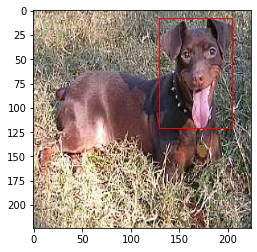

In [32]:
# 再次查看图片：取1张
for image, label in train_dataset.take(1):  # 提取的是一个batch！
    plt.imshow( tf.keras.preprocessing.image.array_to_img( image[0] ) )
    out0, out1, out2, out3, out4 = label
    print(out0[0]) # 26：博美 √
    xmin, ymin, xmax, ymax = out1[0].numpy()*new_width, out2[0].numpy()*new_height, out3[0].numpy()*new_width, out4[0].numpy()*new_height
    
    ax = plt.gci()
    Rect = Rectangle( (xmin,ymin), (xmax-xmin), (ymax-ymin), fill = False, color = 'r' ) 
    ax.axes.add_patch( Rect )
    plt.show()

In [33]:
# 列举后面会用到的变量：
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None,))), types: (tf.float32, (tf.int32, tf.float64, tf.float64, tf.float64, tf.float64))>,
 <BatchDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,), (None,))), types: (tf.float32, (tf.int32, tf.float64, tf.float64, tf.float64, tf.float64))>)

### 6. 模型搭建：

In [34]:
# 全面卷积信息提取部分：
model_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(224, 224, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(1024, (3, 3), activation = 'relu' ),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(2048, activation = 'relu' ),
    tf.keras.layers.Dense(512, activation = 'relu' )
])

In [35]:
# 所有分支前共有的部分：
inputs = tf.keras.layers.Input( shape = (224,224,3) )
x = model_conv(inputs)

In [36]:
# 都是分支而已，彼此直接没有本质不同！
# 分类部分：
out_class = tf.keras.layers.Dense(35, activation = 'softmax', name = 'out_class')(x)
# 回归部分：
out_xmin = tf.keras.layers.Dense(1, name = 'out_xmin')(x)
out_ymin = tf.keras.layers.Dense(1, name = 'out_ymin')(x)
out_xmax = tf.keras.layers.Dense(1, name = 'out_xmax')(x)
out_ymax = tf.keras.layers.Dense(1, name = 'out_ymax')(x)

In [37]:
# 输出汇总：
prediction = [out_class, out_xmin, out_ymin, out_xmax, out_ymax]

In [38]:
# 模型搭建：
model = tf.keras.models.Model( inputs = inputs, outputs = prediction )

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          22007360    input_1[0][0]                    
__________________________________________________________________________________________________
out_class (Dense)               (None, 35)           17955       sequential[1][0]                 
__________________________________________________________________________________________________
out_xmin (Dense)                (None, 1)            513         sequential[1][0]                 
______________________________________________________________________________________________

### 7. 自定义训练：自定义优化器对象、损失函数对象、指标对象

In [40]:
# 自定义优化器对象：训练数据用
optimizer = tf.keras.optimizers.Adam( learning_rate = 0.0001 )

In [41]:
# 自定义损失函数：第一个给真实结果，二个是预测结果！—— train和test可以公用！
class_loss_func = tf.keras.losses.SparseCategoricalCrossentropy()  # 仅train中出现！因为要算总loss_step
xmin_loss_func = tf.keras.losses.MeanSquaredError()
ymin_loss_func = tf.keras.losses.MeanSquaredError()
xmax_loss_func = tf.keras.losses.MeanSquaredError()
ymax_loss_func = tf.keras.losses.MeanSquaredError()

In [42]:
# 自定义指标对象：不断记录！ —— 分类任务不需要loss，只需acc
train_class_accuracy = tf.keras.metrics.Accuracy( 'train_class_acc' )

train_xmin_loss = tf.keras.metrics.Mean('train_xmin_loss')
train_ymin_loss = tf.keras.metrics.Mean('train_ymin_loss')
train_xmax_loss = tf.keras.metrics.Mean('train_xmax_loss')
train_ymax_loss = tf.keras.metrics.Mean('train_ymax_loss')

# --- #

test_class_accuracy = tf.keras.metrics.Accuracy( 'test_class_acc' )

test_xmin_loss = tf.keras.metrics.Mean('test_xmin_loss')
test_ymin_loss = tf.keras.metrics.Mean('test_ymin_loss')
test_xmax_loss = tf.keras.metrics.Mean('test_xmax_loss')
test_ymax_loss = tf.keras.metrics.Mean('test_ymax_loss')

**7.1 自定义每个batch训练、测试函数：**

In [43]:
# 每个batch的 “训练” 函数：
def train_epoch( model, images, label_real ):
    
    # 定义t要跟踪哪些函数的梯度变化：
    with tf.GradientTape() as t: 
        # 5个预测结果：
        class_predict, xmin_predict, ymin_predict, xmax_predict, ymax_predict = model(images)  
        # 损失值中间变量：一个batch整体的（一个值）！
        class_loss = class_loss_func( label_real[0], class_predict )
        xmin_loss = xmin_loss_func( label_real[1], xmin_predict )
        ymin_loss = ymin_loss_func( label_real[2], ymin_predict )
        xmax_loss = xmax_loss_func( label_real[3], xmax_predict )
        ymax_loss = ymax_loss_func( label_real[4], ymax_predict )
        # 每个epoch的总误差：直接求和！
        loss_step = class_loss + xmin_loss + ymin_loss + xmax_loss + ymax_loss
        
    grads = t.gradient( loss_step, model.trainable_variables )          # 对 “总” loss_step做下降！
    optimizer.apply_gradients( zip(grads, model.trainable_variables) )  # 用算好的梯度值优化可训练参数
    
    # 每个batch后的各种指标对象变化：
    train_class_accuracy( label_real[0], tf.argmax(class_predict, axis = 1) )
    train_xmin_loss( xmin_loss ) 
    train_ymin_loss( ymin_loss )
    train_xmax_loss( xmax_loss )
    train_ymax_loss( ymax_loss )

In [44]:
# 每个batch的 “测试” 函数：
def test_epoch( model, images, label_real ):
    class_predict, xmin_predict, ymin_predict, xmax_predict, ymax_predict = model.predict(images)
    xmin_loss = xmin_loss_func( label_real[1], xmin_predict )
    ymin_loss = ymin_loss_func( label_real[2], ymin_predict )
    xmax_loss = xmax_loss_func( label_real[3], xmax_predict )
    ymax_loss = ymax_loss_func( label_real[4], ymax_predict )
    
    # 每个batch后的各种指标对象变化：
    test_class_accuracy( label_real[0], tf.argmax(class_predict, axis = 1) )
    test_xmin_loss( xmin_loss ) 
    test_ymin_loss( ymin_loss )
    test_xmax_loss( xmax_loss )
    test_ymax_loss( ymax_loss )

**7.2 设置检查点：**

In [45]:
import os 

cp_dir = '/home/gaoboyu/学习保存的模型/zdy/'
cp_prefix = os.path.join(cp_dir, 'ckpt')  # 保存的文件都加一个ckpt前缀！

# 设定检查点类：里面是要保存的东西
checkpoint = tf.train.Checkpoint(optimizer = optimizer, model = model)

**7.3 总体训练函数：**

In [46]:
# 每个epoch的结果记录：
train_class_accuracy_results = []

train_xmin_loss_results = []
train_ymin_loss_results = []
train_xmax_loss_results = []
train_ymax_loss_results = []

# --- #

test_class_accuracy_results = []

test_xmin_loss_results = []
test_ymin_loss_results = []
test_xmax_loss_results = []
test_ymax_loss_results = []

# --- #

num_epochs = 50

In [47]:
def train():
    
    # 每个epoch训练：model在不停训练改变！
    for epoch in range(num_epochs):
        
        # 每个batch训练：
        for (images, label_real) in train_dataset:
            train_epoch( model, images, label_real )  # 每个batch的训练
            print('.', end = '')  # 每训练完一个batch，打印一个点；每训练完一个epoch，换一行
        print('')        
        # 每个epoch，记录训练指标：方便画图！
        train_class_accuracy_results.append( train_class_accuracy.result() )
        train_xmin_loss_results.append( train_xmin_loss.result() )
        train_ymin_loss_results.append( train_ymax_loss.result() )
        train_xmax_loss_results.append( train_xmax_loss.result() )
        train_ymax_loss_results.append( train_ymax_loss.result() )
        
        # 每个epoch测试：
        for (images, label_real) in test_dataset:
            test_epoch( model, images, label_real )  # 每个batch的测试
        # 每个epoch，记录测试指标：方便画图！
        test_class_accuracy_results.append( test_class_accuracy.result() )
        test_xmin_loss_results.append( test_xmin_loss.result() )
        test_ymin_loss_results.append( test_ymax_loss.result() )
        test_xmax_loss_results.append( test_xmax_loss.result() )
        test_ymax_loss_results.append( test_ymax_loss.result() )
        
        # 每个epoch结束，打印一次训练指标：
        print('Epoch{}：train_class_acc：{:.5f}，train_xmin_loss：{:.5f}，train_ymin_loss：{:.5f}，train_xmax_loss：{:.5f}，train_ymax_loss：{:.5f}'.format(
            epoch+1,  
            train_class_accuracy.result(),
            train_xmin_loss.result(),
            train_ymin_loss.result(),
            train_xmax_loss.result(),
            train_ymax_loss.result() ) )
        # 每个epoch结束，打印一次测试指标：
        print('Epoch{}：test_class_acc：{:.5f}，test_xmin_loss：{:.5f}，test_ymin_loss：{:.5f}，test_xmax_loss：{:.5f}，test_ymax_loss：{:.5f}'.format(
            epoch+1, 
            test_class_accuracy.result(),
            test_xmin_loss.result(),
            test_ymin_loss.result(),
            test_xmax_loss.result(),
            test_ymax_loss.result() ) )
        
        # 指标对象每个epoch完后重置：
        train_class_accuracy.reset_states()
        train_xmin_loss.reset_states()
        train_ymin_loss.reset_states()
        train_xmax_loss.reset_states()
        train_ymax_loss.reset_states()
        
        test_class_accuracy.reset_states()
        test_xmin_loss.reset_states()
        test_ymin_loss.reset_states()
        test_xmax_loss.reset_states()
        test_ymax_loss.reset_states()
        
        # 检查点保存：每两个epoch保存一次！
        if (epoch + 1) % 2 == 0:
            checkpoint.save( file_prefix = cp_prefix )

In [48]:
# 原始测试结果：epoch = 50
train()

..............................................................................................
Epoch1：train_class_acc：0.05800，train_xmin_loss：0.02823，train_ymin_loss：0.01575，train_xmax_loss：0.05870，train_ymax_loss：0.05188
Epoch1：test_class_acc：0.00000，test_xmin_loss：0.03176，test_ymin_loss：0.01230，test_xmax_loss：0.03679，test_ymax_loss：0.03581
..............................................................................................
Epoch2：train_class_acc：0.07167，train_xmin_loss：0.02337，train_ymin_loss：0.01461，train_xmax_loss：0.02681，train_ymax_loss：0.02695
Epoch2：test_class_acc：0.00000，test_xmin_loss：0.03032，test_ymin_loss：0.01301，test_xmax_loss：0.03193，test_ymax_loss：0.03009
..............................................................................................
Epoch3：train_class_acc：0.06600，train_xmin_loss：0.02225，train_ymin_loss：0.01415，train_xmax_loss：0.02385，train_ymax_loss：0.02698
Epoch3：test_class_acc：0.00000，test_xmin_loss：0.03576，test_ymin_loss：0.01249，test_xmax_loss

KeyboardInterrupt: 

In [49]:
# 模型恢复：
checkpoint.restore( tf.train.latest_checkpoint(cp_dir) )

13 13
22 22
2 2
33 33
18 18
30 30


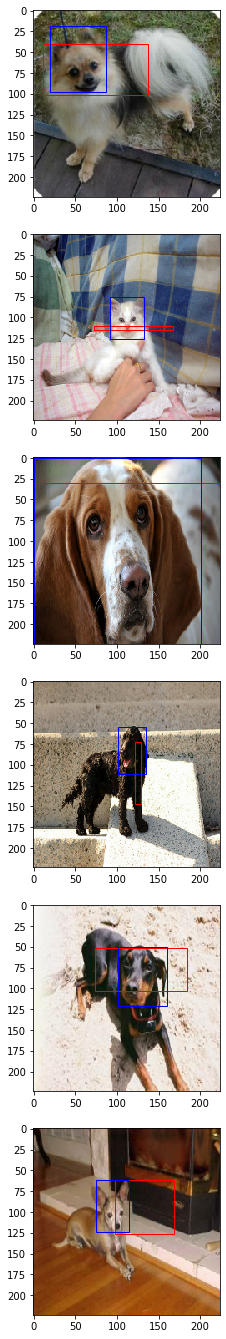

In [51]:
# 画图进行预测：
plt.figure( figsize=(8, 24) )
for (img, label_real) in train_dataset.take(1):  # 只要图
    class_pred, xmin_pred, ymin_pred, xmax_pred, ymax_pred = model.predict(img)
    # 查看6张图：
    for i in range(6):
        plt.subplot(6, 1, i+1)  # 注意：子图数值是从1开始的！不是从0
        plt.imshow( tf.keras.preprocessing.image.array_to_img(img[i]) )  # 将张量转为array
        
        xmin_pred_i, ymin_pred_i, xmax_pred_i, ymax_pred_i = xmin_pred[i]*224, ymin_pred[i]*224, xmax_pred[i]*224, ymax_pred[i]*224
        xmin_real, ymin_real, xmax_real, ymax_real = label_real[1][i]*224, label_real[2][i]*224, label_real[3][i]*224, label_real[4][i]*224
        
        rect1 = Rectangle( (xmin_pred_i, ymin_pred_i), (xmax_pred_i-xmin_pred_i), (ymax_pred_i-ymin_pred_i), fill = False, color = 'red' )
        rect2 = Rectangle( (xmin_real, ymin_real), (xmax_real-xmin_real), (ymax_real-ymin_real), fill = False, color = 'blue')
        
        ax = plt.gca()
        ax.axes.add_patch(rect1)
        ax.axes.add_patch(rect2)
        print( np.argmax(class_pred[i]), label_real[0][i].numpy() )

In [ ]:
model( test_image, training = False )

In [149]:
# 测试部分：
# 顺序编码交叉熵损失函数 + 分类精确度目标函数的使用：
cf = tf.keras.losses.SparseCategoricalCrossentropy()
cf_accuracy = tf.keras.metrics.Accuracy()

In [150]:
a1 = np.array([2, 1, 1])
a2 = np.array([[0.3, 0.2, 0.5], [0.1, 0.88, 0.02], [0.21, 0.69, 0.1]])
print( tf.keras.losses.sparse_categorical_crossentropy(a1,a2) )
print( cf(a1,a2) )
print( cf_accuracy( a1, np.argmax(a2, axis = 1) ) )

tf.Tensor([0.69314718 0.12783337 0.37106368], shape=(3,), dtype=float64)
tf.Tensor(0.3973480761051178, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float32)


In [154]:
# 均方误差的使用：
cf1 = tf.keras.losses.MeanSquaredError()
cf_metrics = tf.keras.metrics.Mean()

In [155]:
b1 = np.array( [0.9821, 0.6722, 0.5262] )
b2 = np.array( [0.9118, 0.5667, 0.5511] )
print( cf1( b1, b2 ) )
print( tf.keras.losses.mean_squared_error(b1,b2) )
print( cf_metrics( b1,b2 ) )

tf.Tensor(0.00556411687284708, shape=(), dtype=float64)
tf.Tensor(0.005564116666666666, shape=(), dtype=float64)
tf.Tensor(0.7717793, shape=(), dtype=float32)


In [156]:
tf.keras.metrics.mean_absolute_error(b1, b2)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0669>

In [158]:
(np.power((0.9821 - 0.9118),2) + np.power((0.6722 - 0.5667),2) + np.power((0.5262 - 0.5511),2) ) / 3

0.005564116666666666

In [159]:
b1 = np.array( [[0.9821], [0.6722], [0.5262]] )
b2 = np.array( [[0.9118], [0.5667], [0.5511]] )
print( tf.keras.losses.mean_squared_error(b1,b2) )

tf.Tensor([0.00494209 0.01113025 0.00062001], shape=(3,), dtype=float64)
